In [1]:
import json
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from models.models_true_data import *
from models.losses import *
from models.metric import *
import datetime
from utils.img_utils import draw_axis
%matplotlib inline
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

Keypoints indexes:
0. SpineBase, 
1. SpineMid, 
2. Neck, 
3. Head, 
4. ShoulderLeft, 
5. ElbowLeft, 
6. WristLeft, 
7. HandLeft, 
8. ShoulderRight, 
9. ElbowRight, 
10. WristRIGHT, 
11. HandRight, 
12. SpineShoulder, 
13. HandTipLeft, 
14. ThumbLeft, 
15. HandTipRight, 
16. ThumbRight

In [31]:
data = pd.read_csv(r"..\07\07\free_3_ID07\data.txt")

In [33]:
df_free_1 = pd.read_csv(r"..\07\07\free_1_ID07\data.txt",sep='\t', header=None)

(array([ 18.,  20.,  10.,  60., 476.,  66.,  17.,  25.,   6.,  16.]),
 array([-31.78290569, -24.53408974, -17.2852738 , -10.03645785,
         -2.7876419 ,   4.46117404,  11.70998999,  18.95880594,
         26.20762188,  33.45643783,  40.70525377]),
 <BarContainer object of 10 artists>)

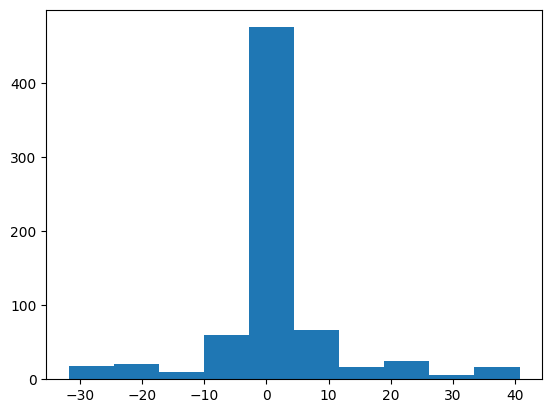

In [36]:
plt.hist(np.array(df_free_1[9]))

1. Extract keypoints from file, adding 0 as uncertainty
2. Keypoints normalization (centralization)
2*. Add groups name and filter nan values? mb before, in keypoint norm. Also with low confidence
3. Training?
For more points in training also change models.py hhp_net function
* check how they are saved. tensor? unpacked? stacked? dimension?
* it is uncertainty in the paper, but confidence in the code!!!!
* we don't filter keypoints with low confidence now because we have gruond truth of the location. However later it should be included into get_normalized function

* with respect to what aew yaw, pitch and roll? if we will add rotation as augm will these angles be different
?


#### TODO:
1. Extract keypoints with keypoints extractor: Resizing will be needed
2. def get_normalised(kpts): include confidence confidence_threshold=-0.0001 # to take also with zero unc, df = df[df.confidence > confidence_threshold]
Question: do we want to train on keypoints with high confidence and then when we do reference we include only those with high confidence; or we also take with 0 confidence but reference only for high confidence or filter is the same for everything
3. When we will have more data change train/test splitting: for test only 2 sub as in original paper(Sequences of subjects 10, 14, 16 and 20 have been used for
testing, the remaining for training.)

They also used as accuracy the percentage of correct estimations (err <15◦)



## Loading functions

### Reading json files

In [7]:
PATHS = ["../07/07/base_1_ID07/data.json","../07/07/base_2_ID07/data.json", "../07/07/free_1_ID07/data.json","../07/07/free_2_ID07/data.json","../07/07/free_3_ID07/data.json"]

In [8]:
#also adds 0 as a uncertainty level
def get_data_from_json(path_to_data, kpt_idx = [0, 1, 4, 8, 12]):
    kpts = []
    outputs = []
    with open(path_to_data, 'r') as file:
        data = json.load(file) 
    #print(len(data))
    for i in range(len(data)):
        #adding 0 as uncertainty
        kpts.append(np.insert(np.array(data[i]['jointsRGB'])[kpt_idx], 2, 1, axis = 1))
        outputs.append([data[i]['shoulder_orientation']['euler']['yaw'],data[i]['shoulder_orientation']['euler']['pitch'],data[i]['shoulder_orientation']['euler']['roll']])
    return np.array(kpts), np.array(outputs)
        

In [9]:
# points with llow confidence are excluded or only not in the mean coiunting?
# then we should add other parameters: kpts, gt_angles, confidence_threshold = 0.0
# and also check that the max distance is not null otherwise drop the point
def get_normalised(kpts):
    kpts_a= kpts.shape[0]
    centers = kpts.mean(axis = 1).reshape(kpts_a, 1, 3)
    max_dist = ((abs(kpts - centers)).max(axis = 1)).reshape(kpts_a, 1, 3)
    kpts[:,:,:2] = (kpts[:,:,:2] - centers[:,:,:2])/max_dist[:,:,:2]
    return kpts

In [10]:
def calculate_stats_in_dataset(data):
#    :mean (float): Mean value of the confidences in the training set;
#            this value is used to normalize the confidence values
#        :std (float): Standard deviation value of the confidences in the training set;
#            this value is used to normalize the confidence values
  
    # extract the 2,5,8,11,14

    mean = np.mean(data[:,:,2])
    var = np.std(data[:,:,2])
    return mean, var


In [11]:
#with open(PATHS[0], 'r') as file:
#    data = json.load(file)
#len(data)
#data[0].keys()
#data[0]['jointsRGB']
#SpineBase, SpineMid, Neck, Head, ShoulderLeft, ElbowLeft, WristLeft, HandLeft, ShoulderRight, 
# ElbowRight, WristRIGHT, HandRight, SpineShoulder, HandTipLeft, ThumbLeft, 
#HandTipRight, ThumbRight
#0,1,4,8, 12
#SpineBase, SpineMid,ShoulderLeft,ShoulderRight, SpineShoulder
#np.array(data[0]['jointsRGB'])[[0,1, 4,8, 12]]
#len(data[0]['jointsRGB'])
#data[0]['shoulder_orientation']['euler']
#yaw pitch roll
#in reality pitch yaw roll 
#return np.asarray([yaw, -pitch, roll], dtype=float), np.asarray([x_pos, y_pos, z_pos], dtype=float)
#data[0]['shoulder_orientation']['euler']['pitch']

## Training with 5 keypoints

Random shuffle for small dataset only

For normalization:
face_kpts = face_kpts.get_normalised(confidence_threshold=-0.0001) # to take also with zero unc
    # transform to tensor
    #face_kpts_tf = face_kpts.get_tensor()
    if extended:
        face_kpts_np = face_kpts.get_numpy_extended()
    else:
        face_kpts_np = face_kpts.get_numpy()
    # face_kpts_np = np.asarray(face_kpts)
    
    return face_kpts_np

def get_normalised(self, confidence_threshold: float = 0.0) -> KeyPoints2D:
        """Normalize points.

        Args:
            pose: list of points (x, y, confidence)
            confidence_threshold: confidence threshold for
                filtering key points, points under threshold are not returned

        Returns:
            list of points (x,y, confidence)
        """
        df = self.to_df()
        df = df[df.confidence > confidence_threshold]
        center_x, center_y = self.get_centers(confidence_threshold)
        max_dist_x = abs(df.x - center_x).max()
        max_dist_y = abs(df.y - center_y).max()

        # Normalise data w.r.t centers
        if (max_dist_x != 0.0) & (max_dist_y != 0.0):
            df[["x", "y"]] = (df[["x", "y"]] - (center_x, center_y)) / (
                max_dist_x,
                max_dist_y,
            )
        else:
            logger.error(
                "Filtered key points have zero distance: "
                "max_dist_x=%d; max_dist_y=%d",
                max_dist_x,
                max_dist_y,
            )

        return KeyPoints2D(
            df.index.to_list(),
            df.to_numpy().tolist(),
            model_type=self.model_type,
        )

def get_numpy(
        self, data_type=tf.float32, model_type: pose.ModelType = pose.ModelType.HHP_NET
    ):
        """Return x,y,confidence array."""
        joints = self.get_joints()
        match model_type:
            case pose.ModelType.HHP_NET:
                return np.expand_dims(
                        self.to_df()
                        .reindex(
                            [
                                joints(pose.Joints.NOSE),
                                joints(pose.Joints.L_EYE),
                                joints(pose.Joints.R_EYE),
                                joints(pose.Joints.L_EAR),
                                joints(pose.Joints.R_EAR),
                            ]
                        )
                        .to_numpy()
                        .ravel(),
                        0,
                    )
            case _:
                raise NotImplementedError

    def get_numpy_extended(
        self, data_type=tf.float32, model_type: pose.ModelType = pose.ModelType.HHP_NET
    ):
        """Return x,y,confidence array."""
        joints = self.get_joints()
        match model_type:
            case pose.ModelType.HHP_NET:
                return np.expand_dims(
                        self.to_df()
                        .reindex(
                            [
                                joints(pose.Joints.NOSE),
                                joints(pose.Joints.L_EYE),
                                joints(pose.Joints.R_EYE),
                                joints(pose.Joints.L_EAR),
                                joints(pose.Joints.R_EAR),
                                joints(pose.Joints.R_MOUTH),
                                joints(pose.Joints.L_MOUTH),
                                joints(pose.Joints.R_EYE_OUTER),
                                joints(pose.Joints.R_EYE_INNER),
                                joints(pose.Joints.L_EYE_OUTER),
                                joints(pose.Joints.L_EYE_INNER),
                            ]
                        )
                        .to_numpy()
                        .ravel(),
                        0,
                    )
            case _:
                raise NotImplementedError

In [5]:
#input_kpts, output_angles = get_data_from_json(PATHS[2])
#input_kpts.shape
#input_kpts.mean(axis = 1).shape
#center = input_kpts.mean(axis = 1).reshape((714,1,3))
#input_kpts[0]
#center[0]
#print((input_kpts - center)[0])
#print((input_kpts - center).shape)
#print((shape)(abs(input_kpts - center)).max(axis = 1)).
#max_dist = ((abs(input_kpts - center)).max(axis = 1)).reshape(714,1,3)
#input_kpts[:,:,:2] = (input_kpts[:,:,:2] - center[:,:,:2])/max_dist[:,:,:2]
#input_kpts.shape

#### Normalization(Centralization)

In [22]:
#input_kpts_norm = get_normalised(input_kpts)

#### Training
We use just shuffle and train test split because we have only one subj for now
First we will split on train, validation and test. Then we will leave some poeple for tgest, the rest will spit on traiing and validation

In [25]:
input_kpts, output_angles = get_data_from_json(PATHS[0])
input_kpts_norm = get_normalised(input_kpts)

for i in range(1,len(PATHS)):
    input_kpts_new, output_angles_new = get_data_from_json(PATHS[i])
    input_kpts_norm_new = get_normalised(input_kpts_new)
    input_kpts_norm = np.append(input_kpts_norm, input_kpts_new, axis = 0)
    output_angles = np.append(output_angles, output_angles_new, axis = 0)


In [26]:
#output_angles.shape
#print(input_kpts_norm[0])
#print(input_kpts_norm[0].reshape(1,-1))

(4861, 3)

Reshape is nescessary

In [28]:
train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

input_kpts_norm_resh = input_kpts_norm.reshape(input_kpts_norm.shape[0], -1,1)
# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(input_kpts_norm_resh, output_angles, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

print(x_train.shape, x_val.shape, x_test.shape)

(3888, 15, 1) (486, 15, 1) (487, 15, 1)


In [34]:
current_time = datetime.datetime.now()
today = datetime.date.today()
d1 = '' + today.strftime("%d-%m-%Y") + '_' + str(current_time.hour) + '_' + str(current_time.minute)
folder_results = r"results"

mean_uncertainty_in_dataset, std_uncertainty_in_dataset = calculate_stats_in_dataset(input_kpts_norm)
std_uncertainty_in_dataset = 10**(-6)

log_dir = "results/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = keras.callbacks.EarlyStopping(
                # Stop training when `val_loss` is no longer improving
                monitor="val_loss",
                # "no longer improving" being defined as "no better than 1e-2 less"
                min_delta=0.001, # almost everythinh is an improvemente
                # "no longer improving" being further defined as "for at least 5 epochs"
                patience=5,
                verbose=1,
                restore_best_weights = False, # take the weights 5 epochs after best
        )

my_results = {}
my_results['yaw_MAE_hpe'] = []
my_results['pitch_MAE_hpe'] = []
my_results['roll_MAE_hpe'] = []

    # https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators
    # SS = GroupShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    # for train_index, test_index in SS.split(my_data, groups=groups):i=0
my_model = hhp_net(mean=mean_uncertainty_in_dataset, std=std_uncertainty_in_dataset, alpha=1)
        
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000, # new
        decay_rate=0.5,
        staircase=True)



In [35]:
my_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),  # Optimizer
                # Loss function to minimize
                loss=[Mse_loss_single_output_with_uncertainty(), Mse_loss_single_output_with_uncertainty(),
                      Mse_loss_single_output_with_uncertainty()],
                # List of metrics to monitor
                # metrics=[keras.metrics.MeanSquaredError()],
                metrics={'yaw'  : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg()],
                         'pitch': [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg()],
                         'roll' : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg()]},
                # metrics = {'yaw': keras.metrics.MeanSquaredError(), 'pitch': keras.metrics.MeanSquaredError(), 'roll': keras.metrics.MeanSquaredError()},
        )


In [36]:
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 15, 1)]      0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, 5, 1)         0           ['input[0][0]']                  
                                                                                                  
 lambda_5 (Lambda)              (None, 5, 1)         0           ['input[0][0]']                  
                                                                                                  
 lambda_4 (Lambda)              (None, 5, 1)         0           ['input[0][0]']                  
                                                                                            

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_train, }, {'yaw'  : y_train[:, [0]].squeeze(),
                                                                                   'pitch': y_train[:, [1]].squeeze(),
                                                                                   'roll' : y_train[:, [2]].squeeze()}))
        

In [49]:
val_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_val, }, {'yaw'  : y_val[:, [0]].squeeze(),
                                                                                 'pitch': y_val[:, [1]].squeeze(),
                                                                                 'roll' : y_val[:, [2]].squeeze()}))

In [50]:
test_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_test, }, {'yaw'  : y_test[:, [0]].squeeze(),
                                                                                 'pitch': y_test[:, [1]].squeeze(),
                                                                                 'roll' : y_test[:, [2]].squeeze()}))

In [51]:
train_dataset = train_dataset.shuffle(buffer_size=300, reshuffle_each_iteration=True)

In [52]:
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [41]:
EPOCHS = 1000
history = my_model.fit(train_dataset, epochs=EPOCHS,
                               callbacks=[tensorboard_callback, early_stopping_callback], validation_data=val_dataset)

Epoch 1/1000
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
49/60 [=======================>......] - ETA: 0s - loss: 34.8866 - yaw_loss: 13.3036 - pitch_loss: 20.8732 - roll_loss: 0.7098 - yaw_MAE_hpe: 5.0914 - yaw_Save_UNC: 22.2557 - pitch_MAE_hpe: 9.4001 - pitch_Save_UNC: 52.1203 - roll_MAE_hpe: 0.5178 - roll_Save_UNC: 0.7192 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
60/60 [==============================] - 3s 13ms/step - loss: 29.6966 - yaw_loss: 11.4079 - pitch_loss: 17.6961 - roll_loss: 0.5925 - yaw_MAE_hpe: 5.7182 - yaw_Save_UNC:

In [53]:
results = my_model.evaluate(test_dataset, return_dict=True)

7/7 [==============================] - 0s 3ms/step - loss: 4.3579 - yaw_loss: 2.3168 - pitch_loss: 2.2147 - roll_loss: -0.1736 - yaw_MAE_hpe: 4.1818 - yaw_Save_UNC: 8.4613 - pitch_MAE_hpe: 5.7122 - pitch_Save_UNC: 6.1345 - roll_MAE_hpe: 0.4348 - roll_Save_UNC: 0.5301


In [55]:
results

{'loss': 4.357892036437988,
 'yaw_loss': 2.31681489944458,
 'pitch_loss': 2.2147231101989746,
 'roll_loss': -0.17364569008350372,
 'yaw_MAE_hpe': 4.181773662567139,
 'yaw_Save_UNC': 8.461270332336426,
 'pitch_MAE_hpe': 5.712221145629883,
 'pitch_Save_UNC': 6.134501934051514,
 'roll_MAE_hpe': 0.43476200103759766,
 'roll_Save_UNC': 0.5300778150558472}

In [108]:
res = my_model.predict(test_dataset)

In [109]:
res

[array([[1.0405717 , 3.517111  ],
        [1.2816662 , 3.938279  ],
        [2.5744815 , 6.3441596 ],
        [0.80884033, 3.0340793 ],
        [0.26605904, 1.7550855 ],
        [0.32622188, 1.8940187 ],
        [1.096074  , 3.643006  ],
        [2.914997  , 7.097886  ],
        [0.23961796, 1.6894052 ],
        [0.36131334, 1.9783065 ],
        [0.35549337, 1.960913  ],
        [0.4084496 , 2.093382  ],
        [0.5691055 , 2.4827287 ],
        [1.4471301 , 4.21502   ],
        [0.59397113, 2.5319204 ],
        [1.7175881 , 4.685183  ],
        [0.7742443 , 2.9880488 ],
        [0.23855607, 1.6869109 ],
        [0.33445078, 1.9129896 ],
        [1.7106599 , 4.7017417 ],
        [0.33037007, 1.9003711 ],
        [2.9911308 , 7.204266  ],
        [1.7006907 , 4.6571975 ],
        [0.30220616, 1.8396847 ],
        [1.6347978 , 4.592476  ],
        [0.992231  , 3.4476192 ],
        [0.4910841 , 2.290909  ],
        [0.23590009, 1.6815628 ],
        [0.87905186, 3.207277  ],
        [0.734

#### Visualize

In [68]:
img = cv2.imread(r"..\07\07\free_1_ID07\RGB\000484_RGB.png")
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(im_rgb.shape)

(1080, 1920, 3)


In [80]:
input_kpts, output_angles = get_data_from_json("../07/07/free_1_ID07/data.json")

In [82]:
frame_index = 484
input_kpts_norm = get_normalised(input_kpts)[frame_index,:,:]
output_angles= output_angles[frame_index, :]

In [85]:
input_kpts_norm = input_kpts_norm.reshape(1,15)

In [87]:
res = my_model.predict(input_kpts_norm)

In [94]:
res[0]

array([[1.9973544, 5.1758814]], dtype=float32)

In [97]:
yaw_res = res[0][0,0]
pitch_res = res[1][0,0]
roll_res = res[2][0,0]

In [ ]:
draw_axis(yaw_res, pitch_res, roll_res, img_labeled, tdx=x, tdy=y, length_axis=100)

In [21]:
def show_results(frame_path):
    
    data = pd.read_csv(frame_path[:-18]+"data.txt", sep='\t', header=None)
    frame_int = int(frame_path[-11:-8])
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    spine_shoulder_rgb = [125, 126]
    x,y = data.iloc[frame_int, spine_shoulder_rgb]
    x = int(x)
    y = int(y)

    input_kpts, output_angles = get_data_from_json(frame_path[:-18]+"data.json")
    input_kpts_norm = get_normalised(input_kpts)[frame_int,:,:]
    output_angles= output_angles[frame_int, :]    
    input_kpts_norm = input_kpts_norm.reshape(1,15)
    res = my_model.predict(input_kpts_norm)
    yaw_pr = res[0][0,0]
    pitch_pr = res[1][0,0]
    roll_pr = res[2][0,0]
    print(yaw_pr, pitch_pr, roll_pr)
    print(output_angles)
    color = (255, 0, 0) 
    radius = 10
    thickness = 2
    img_labeled = cv2.circle(img, (int(x), int(y)), radius, color, thickness)
    img_labeled = draw_axis(yaw_pr, pitch_pr, roll_pr, img_labeled, tdx=x, tdy=y, length_axis=100)
    return(img_labeled)


In [90]:
def display_results(data, frame_path, yaw_pr, pitch_pr, roll_pr):

    frame_int = int(frame_path[-11:-8])
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    shoulder_euler = [9,10,11]
    spine_shoulder_rgb = [125, 126]
    x,y = data.iloc[frame_int, spine_shoulder_rgb]
    x = int(x)
    y = int(y)
    
    color = (255, 0, 0) 
    radius = 10
    thickness = 2
    img_labeled = cv2.circle(img, (int(x), int(y)), radius, color, thickness)
    img_labeled = draw_axis(yaw_pr, pitch_pr, roll_pr, img_labeled, tdx=x, tdy=y, length_axis=100)
    return(img_labeled)


In [71]:
def display_labels(data, frame_path):

    frame_int = int(frame_path[-11:-8])
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    shoulder_euler = [9,10,11]
    spine_shoulder_rgb = [125, 126]
    x,y = data.iloc[frame_int, spine_shoulder_rgb]
    x = int(x)
    y = int(y)
    yaw, roll, pitch = data.iloc[frame_int, shoulder_euler]
    color = (255, 0, 0) 
    radius = 10
    thickness = 2
    img_labeled = cv2.circle(img, (int(x), int(y)), radius, color, thickness)
    img_labeled = draw_axis(yaw, pitch, roll, img_labeled, tdx=x, tdy=y, length_axis=100)
    return(img_labeled)


In [74]:
df_free_1 = pd.read_csv(r"..\07\07\free_1_ID07\data.txt",sep='\t', header=None)

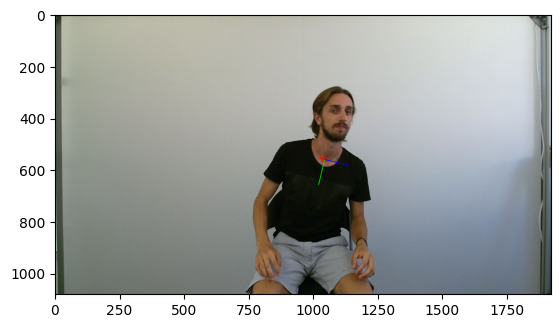

In [77]:
plt.imshow(display_labels(df_free_1, r"..\07\07\free_1_ID07\RGB\000484_RGB.png"))

In [92]:
yaw_res

array([1.9973544, 5.1758814], dtype=float32)

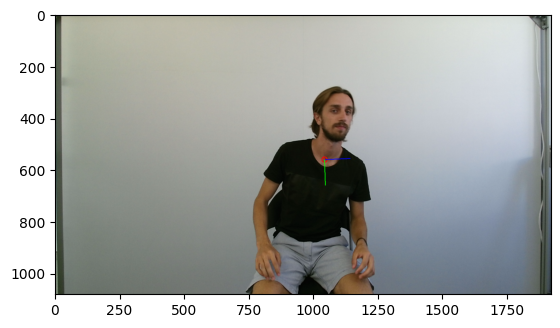

In [98]:
plt.imshow(display_results(df_free_1, r"..\07\07\free_1_ID07\RGB\000484_RGB.png", yaw_res, pitch_res, roll_res))

x red  roll
y green   pitch
z blue  yaw

1.9973544 6.1148396 -1.7210338
[ 3.14043397 13.43496615 -2.51250496]


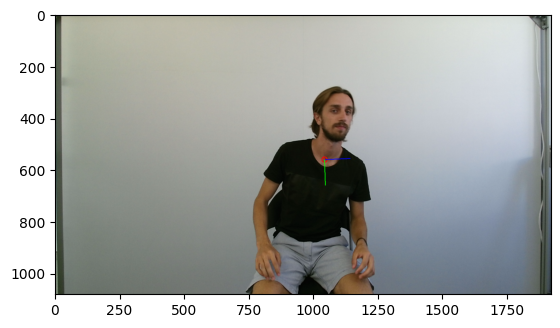

In [124]:
path = "../07/07/free_1_ID07/RGB/000484_RGB.png"
plt.imshow(show_results(path))


## Training with more keypoints

In [3]:
with open(PATHS[0], 'r') as file:
    data = json.load(file)

In [6]:
data[0]['jointsRGB']
#SpineBase, SpineMid, Neck, Head, ShoulderLeft, ElbowLeft, WristLeft, HandLeft, ShoulderRight, 
# ElbowRight, WristRIGHT, HandRight, SpineShoulder, HandTipLeft, ThumbLeft, 
#HandTipRight, ThumbRight
#0:13

[[978.010498046875, 903.2599487304688],
 [975.5140991210938, 688.1762084960938],
 [974.968017578125, 497.87701416015625],
 [970.546142578125, 387.2979736328125],
 [852.3429565429688, 577.2518310546875],
 [829.706298828125, 755.6754760742188],
 [826.4811401367188, 875.065185546875],
 [821.2337646484375, 953.8345947265625],
 [1092.564453125, 574.3960571289062],
 [1119.0587158203125, 747.1553955078125],
 [1095.33935546875, 900.4115600585938],
 [1110.394775390625, 892.96142578125],
 [975.0156860351562, 543.528076171875],
 [813.4839477539062, 998.292724609375],
 [858.6400146484375, 962.6111450195312],
 [1118.479248046875, 937.4022216796875],
 [1150.022216796875, 852.1605224609375]]

In [16]:
PATHS = ["../07/07/base_1_ID07/data.json","../07/07/base_2_ID07/data.json", "../07/07/free_1_ID07/data.json","../07/07/free_2_ID07/data.json","../07/07/free_3_ID07/data.json"]

In [3]:
28*25

700

In [4]:
0.7*319

223.29999999999998

In [17]:
input_kpts, output_angles = get_data_from_json(PATHS[0], kpt_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12])
input_kpts_norm = get_normalised(input_kpts)

for i in range(1,len(PATHS)):
    input_kpts_new, output_angles_new = get_data_from_json(PATHS[i],kpt_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12])
    input_kpts_norm_new = get_normalised(input_kpts_new)
    input_kpts_norm = np.append(input_kpts_norm, input_kpts_new, axis = 0)
    output_angles = np.append(output_angles, output_angles_new, axis = 0)


In [18]:
train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

input_kpts_norm_resh = input_kpts_norm.reshape(input_kpts_norm.shape[0], -1,1)
# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(input_kpts_norm_resh, output_angles, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

print(x_train.shape, x_val.shape, x_test.shape)

(3888, 39, 1) (486, 39, 1) (487, 39, 1)


In [11]:
#self.score = tf.reduce_mean(tf.where((tf.abs(tf.subtract(y_pred, y_true)) < 15)))
#self.score = tf.reduce_mean(tf.where((tf.abs(tf.subtract(y_pred, y_true)) < 15), 1, 0))
#y_test[:,0].shape

(487,)

In [17]:
#a = tf.convert_to_tensor(np.array([0,1,2,3,4]))
#b = tf.convert_to_tensor(np.array([10,11,12,20,21]))

In [19]:
#tf.abs(tf.subtract(a,b)) < 15

In [20]:

#tf.where((tf.abs(tf.subtract(a,b)) < 15), 1, 0)


In [21]:
#c = tf.reduce_mean(tf.cast((tf.where((tf.abs(tf.subtract(a,b)) < 15), 1, 0)), tf.float16))


In [22]:
current_time = datetime.datetime.now()
today = datetime.date.today()
d1 = '' + today.strftime("%d-%m-%Y") + '_' + str(current_time.hour) + '_' + str(current_time.minute)
folder_results = r"results"

mean_uncertainty_in_dataset, std_uncertainty_in_dataset = calculate_stats_in_dataset(input_kpts_norm)
std_uncertainty_in_dataset = 10**(-6)

log_dir = "results/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = keras.callbacks.EarlyStopping(
                # Stop training when `val_loss` is no longer improving
                monitor="val_loss",
                # "no longer improving" being defined as "no better than 1e-2 less"
                min_delta=0.001, # almost everythinh is an improvemente
                # "no longer improving" being further defined as "for at least 5 epochs"
                patience=5,
                verbose=1,
                restore_best_weights = False, # take the weights 5 epochs after best
        )

my_results = {}
my_results['yaw_MAE_hpe'] = []
my_results['pitch_MAE_hpe'] = []
my_results['roll_MAE_hpe'] = []

    # https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators
    # SS = GroupShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    # for train_index, test_index in SS.split(my_data, groups=groups):i=0
my_model_all = hhp_net_all_points(mean=mean_uncertainty_in_dataset, std=std_uncertainty_in_dataset, a = 39, alpha=1)
        
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000, # new
        decay_rate=0.5,
        staircase=True)



In [23]:
my_model_all.compile(
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),  # Optimizer
                # Loss function to minimize
                loss=[Mse_loss_single_output_with_uncertainty(), Mse_loss_single_output_with_uncertainty(),
                      Mse_loss_single_output_with_uncertainty()],
                # List of metrics to monitor
                # metrics=[keras.metrics.MeanSquaredError()],
                metrics={'yaw'  : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()],
                         'pitch': [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()],
                         'roll' : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()]},
                # metrics = {'yaw': keras.metrics.MeanSquaredError(), 'pitch': keras.metrics.MeanSquaredError(), 'roll': keras.metrics.MeanSquaredError()},
        )


In [24]:
my_model_all.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 39, 1)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 13, 1)        0           ['input[0][0]']                  
                                                                                                  
 lambda_2 (Lambda)              (None, 13, 1)        0           ['input[0][0]']                  
                                                                                                  
 lambda_1 (Lambda)              (None, 13, 1)        0           ['input[0][0]']                  
                                                                                              

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_train, }, {'yaw'  : y_train[:, [0]].squeeze(),
                                                                                   'pitch': y_train[:, [1]].squeeze(),
                                                                                   'roll' : y_train[:, [2]].squeeze()}))
        
val_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_val, }, {'yaw'  : y_val[:, [0]].squeeze(),
                                                                                 'pitch': y_val[:, [1]].squeeze(),
                                                                                 'roll' : y_val[:, [2]].squeeze()}))
test_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_test, }, {'yaw'  : y_test[:, [0]].squeeze(),
                                                                                 'pitch': y_test[:, [1]].squeeze(),
                                                                                 'roll' : y_test[:, [2]].squeeze()}))
train_dataset = train_dataset.shuffle(buffer_size=300, reshuffle_each_iteration=True)
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)


In [26]:
EPOCHS = 1000
history = my_model_all.fit(train_dataset, epochs=EPOCHS,
                               callbacks=[tensorboard_callback, early_stopping_callback], validation_data=val_dataset)

Epoch 1/1000
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_4:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_5:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_6:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_4:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_5:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_6:0", shape=(1,), dtype=int32)
58/60 [============================>.] - ETA: 0s - loss: 26.9718 - yaw_loss: 10.1689 - pitch_loss: 16.2962 - roll_loss: 0.5067 - yaw_MAE_hpe: 5.5627 - yaw_Save_UNC: 8.9986 - yaw_angle_accuracy: 0.8750 - pitch_MAE_hpe: 8.8350 - pitch_Save_UNC: 15.3745 - pi

In [27]:
results = my_model_all.evaluate(test_dataset, return_dict=True)
results

7/7 [==============================] - 0s 2ms/step - loss: 2.1712 - yaw_loss: 2.0325 - pitch_loss: 1.5435 - roll_loss: -1.4048 - yaw_MAE_hpe: 3.8320 - yaw_Save_UNC: 6.2888 - yaw_angle_accuracy: 0.9375 - pitch_MAE_hpe: 3.0529 - pitch_Save_UNC: 3.3204 - pitch_angle_accuracy: 1.0000 - roll_MAE_hpe: 0.2132 - roll_Save_UNC: 0.2276 - roll_angle_accuracy: 1.0000


{'loss': 2.171217203140259,
 'yaw_loss': 2.032496690750122,
 'pitch_loss': 1.543474793434143,
 'roll_loss': -1.4047542810440063,
 'yaw_MAE_hpe': 3.832007884979248,
 'yaw_Save_UNC': 6.288793563842773,
 'yaw_angle_accuracy': 0.9375,
 'pitch_MAE_hpe': 3.0529122352600098,
 'pitch_Save_UNC': 3.320371389389038,
 'pitch_angle_accuracy': 1.0,
 'roll_MAE_hpe': 0.21319419145584106,
 'roll_Save_UNC': 0.2276468575000763,
 'roll_angle_accuracy': 1.0}

In [28]:
results = my_model_all.evaluate(test_dataset, return_dict=True)
results

1/7 [===>..........................] - ETA: 0s - loss: 1.4753 - yaw_loss: 1.9392 - pitch_loss: 1.3476 - roll_loss: -1.8115 - yaw_MAE_hpe: 5.2007 - yaw_Save_UNC: 6.2815 - yaw_angle_accuracy: 0.9062 - pitch_MAE_hpe: 2.7514 - pitch_Save_UNC: 3.5030 - pitch_angle_accuracy: 0.9844 - roll_MAE_hpe: 0.1914 - roll_Save_UNC: 0.2117 - roll_angle_accuracy: 1.0000

7/7 [==============================] - 0s 2ms/step - loss: 2.1712 - yaw_loss: 2.0325 - pitch_loss: 1.5435 - roll_loss: -1.4048 - yaw_MAE_hpe: 3.8320 - yaw_Save_UNC: 6.2888 - yaw_angle_accuracy: 0.9375 - pitch_MAE_hpe: 3.0529 - pitch_Save_UNC: 3.3204 - pitch_angle_accuracy: 1.0000 - roll_MAE_hpe: 0.2132 - roll_Save_UNC: 0.2276 - roll_angle_accuracy: 1.0000


{'loss': 2.171217203140259,
 'yaw_loss': 2.032496690750122,
 'pitch_loss': 1.543474793434143,
 'roll_loss': -1.4047542810440063,
 'yaw_MAE_hpe': 3.832007884979248,
 'yaw_Save_UNC': 6.288793563842773,
 'yaw_angle_accuracy': 0.9375,
 'pitch_MAE_hpe': 3.0529122352600098,
 'pitch_Save_UNC': 3.320371389389038,
 'pitch_angle_accuracy': 1.0,
 'roll_MAE_hpe': 0.21319419145584106,
 'roll_Save_UNC': 0.2276468575000763,
 'roll_angle_accuracy': 1.0}

{'loss': 4.357892036437988,

 'yaw_loss': 2.31681489944458,

 'pitch_loss': 2.2147231101989746,

 'roll_loss': -0.17364569008350372,

 'yaw_MAE_hpe': 4.181773662567139,

 'yaw_Save_UNC': 8.461270332336426,

 'pitch_MAE_hpe': 5.712221145629883,

 'pitch_Save_UNC': 6.134501934051514,

 'roll_MAE_hpe': 0.43476200103759766,
 
 'roll_Save_UNC': 0.5300778150558472}

In [20]:
history['yaw_loss']

In [31]:
def show_results(frame_path, model, kpt_idx):
    
    data = pd.read_csv(frame_path[:-18]+"data.txt", sep='\t', header=None)
    frame_int = int(frame_path[-11:-8])
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    spine_shoulder_rgb = [125, 126]
    x,y = data.iloc[frame_int, spine_shoulder_rgb]
    x = int(x)
    y = int(y)

    input_kpts, output_angles = get_data_from_json(frame_path[:-18]+"data.json", kpt_idx = kpt_idx)
    input_kpts_norm = get_normalised(input_kpts)[frame_int,:,:]
    output_angles= output_angles[frame_int, :]    
    input_kpts_norm = input_kpts_norm.reshape(1,-1)
    res = model.predict(input_kpts_norm)
    yaw_pr = res[0][0,0]
    pitch_pr = res[1][0,0]
    roll_pr = res[2][0,0]
    print(yaw_pr, pitch_pr, roll_pr)
    print(output_angles)
    color = (255, 0, 0) 
    radius = 10
    thickness = 2
    img_labeled = cv2.circle(img, (int(x), int(y)), radius, color, thickness)
    img_labeled = draw_axis(yaw_pr, pitch_pr, roll_pr, img_labeled, tdx=x, tdy=y, length_axis=100)
    return(img_labeled)


In [17]:

res = my_model_all.predict(test_dataset)

In [21]:
res[0][0,0]

1.6547192

In [22]:
y_test

array([[  1.45743502,   1.59140186,  -2.51250496],
       [-10.3954245 ,   4.53315148,  -1.22493474],
       [  8.72405281,  26.39062587,  -0.92835264],
       ...,
       [-39.78806721,  -0.17290338,  -1.60435254],
       [  0.87468941,  -1.0059031 ,  -1.60435254],
       [  0.11038223,   3.63575765,  -0.92835264]])

0.10861413 12.282318 -1.6161513
[ 3.14043397 13.43496615 -2.51250496]


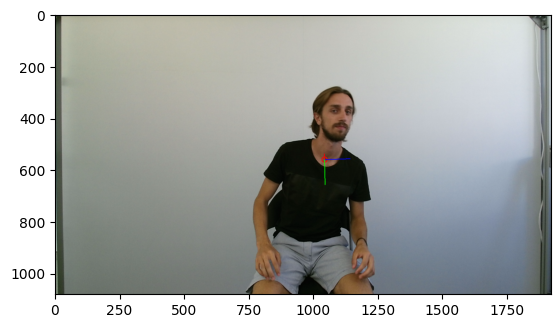

In [32]:
path = "../07/07/free_1_ID07/RGB/000484_RGB.png"
plt.imshow(show_results(path, model = my_model_all, kpt_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12]))

### Extracting keypoints:
1. MoveNet
2. AlphaPose

shoulders-hips
shoulders-hips-elbows-wrists
get 6 output_angles
check accuracy

1. Create another metric: percentage_angle that will estimate an error as 20 percent of -> add augmentations -> different loss? unbalanced dataset sample more with higher degrees?
2. Having only body estimation as a task change inputs: shoulders-hips
shoulders-hips-elbows-wrists
3. get 6 output angles
4. add movenet and alphapose

### Shoulder-hips keypoints model: shoulder-spinebase and shoulders-spinemid

Keypoints indexes:

0. SpineBase, 
1. SpineMid, 
4. ShoulderLeft, 
8. ShoulderRight, 


In [13]:
PATHS = ["../07/07/base_1_ID07/data.json","../07/07/base_2_ID07/data.json", "../07/07/free_1_ID07/data.json","../07/07/free_2_ID07/data.json","../07/07/free_3_ID07/data.json"]

kpts_sh_sb = [0,2,3]
input_kpts, output_angles = get_data_from_json(PATHS[0], kpt_idx = kpts_sh_sb)
input_kpts_norm = get_normalised(input_kpts)

for i in range(1,len(PATHS)):
    input_kpts_new, output_angles_new = get_data_from_json(PATHS[i],kpt_idx = kpts_sh_sb)
    input_kpts_norm_new = get_normalised(input_kpts_new)
    input_kpts_norm = np.append(input_kpts_norm, input_kpts_new, axis = 0)
    output_angles = np.append(output_angles, output_angles_new, axis = 0)


train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

input_kpts_norm_resh = input_kpts_norm.reshape(input_kpts_norm.shape[0], -1,1)
# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(input_kpts_norm_resh, output_angles, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

print(x_train.shape, x_val.shape, x_test.shape)



(3888, 9, 1) (486, 9, 1) (487, 9, 1)


In [15]:
current_time = datetime.datetime.now()
today = datetime.date.today()
d1 = '' + today.strftime("%d-%m-%Y") + '_' + str(current_time.hour) + '_' + str(current_time.minute)
folder_results = r"results"

mean_uncertainty_in_dataset, std_uncertainty_in_dataset = calculate_stats_in_dataset(input_kpts_norm)
std_uncertainty_in_dataset = 10**(-6)

log_dir = "results/logs/fit/" + "sb_choulder_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = keras.callbacks.EarlyStopping(
                # Stop training when `val_loss` is no longer improving
                monitor="val_loss",
                # "no longer improving" being defined as "no better than 1e-2 less"
                min_delta=0.001, # almost everythinh is an improvemente
                # "no longer improving" being further defined as "for at least 5 epochs"
                patience=5,
                verbose=1,
                restore_best_weights = False, # take the weights 5 epochs after best
        )

my_results = {}
my_results['yaw_MAE_hpe'] = []
my_results['pitch_MAE_hpe'] = []
my_results['roll_MAE_hpe'] = []

    # https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators
    # SS = GroupShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    # for train_index, test_index in SS.split(my_data, groups=groups):i=0
my_model_all = hhp_net_all_points(mean=mean_uncertainty_in_dataset, std=std_uncertainty_in_dataset, a = 9, alpha=1)
        
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000, # new
        decay_rate=0.5,
        staircase=True)


my_model_all.compile(
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),  # Optimizer
                # Loss function to minimize
                loss=[Mse_loss_single_output_with_uncertainty(), Mse_loss_single_output_with_uncertainty(),
                      Mse_loss_single_output_with_uncertainty()],
                # List of metrics to monitor
                # metrics=[keras.metrics.MeanSquaredError()],
                metrics={'yaw'  : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()],
                         'pitch': [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()],
                         'roll' : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()]},
                # metrics = {'yaw': keras.metrics.MeanSquaredError(), 'pitch': keras.metrics.MeanSquaredError(), 'roll': keras.metrics.MeanSquaredError()},
        )

my_model_all.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 9, 1)]       0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, 3, 1)         0           ['input[0][0]']                  
                                                                                                  
 lambda_5 (Lambda)              (None, 3, 1)         0           ['input[0][0]']                  
                                                                                                  
 lambda_4 (Lambda)              (None, 3, 1)         0           ['input[0][0]']                  
                                                                                            

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_train, }, {'yaw'  : y_train[:, [0]].squeeze(),
                                                                                   'pitch': y_train[:, [1]].squeeze(),
                                                                                   'roll' : y_train[:, [2]].squeeze()}))
        
val_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_val, }, {'yaw'  : y_val[:, [0]].squeeze(),
                                                                                 'pitch': y_val[:, [1]].squeeze(),
                                                                                 'roll' : y_val[:, [2]].squeeze()}))
test_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_test, }, {'yaw'  : y_test[:, [0]].squeeze(),
                                                                                 'pitch': y_test[:, [1]].squeeze(),
                                                                                 'roll' : y_test[:, [2]].squeeze()}))
train_dataset = train_dataset.shuffle(buffer_size=300, reshuffle_each_iteration=True)
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

EPOCHS = 1000
history = my_model_all.fit(train_dataset, epochs=EPOCHS,
                               callbacks=[tensorboard_callback, early_stopping_callback], validation_data=val_dataset)

Epoch 1/1000
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_4:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_5:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_6:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_4:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_5:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_6:0", shape=(1,), dtype=int32)
50/60 [========================>.....] - ETA: 0s - loss: 37.9445 - yaw_loss: 14.1302 - pitch_loss: 23.1508 - roll_loss: 0.6635 - yaw_MAE_hpe: 5.8865 - yaw_Save_UNC: 23.4595 - yaw_angle_accuracy: 0.9062 - pitch_MAE_hpe: 8.4793 - pitch_Save_UNC: 37.8036 - p

In [17]:
results = my_model_all.evaluate(test_dataset, return_dict=True)
results

7/7 [==============================] - 0s 3ms/step - loss: 5.1194 - yaw_loss: 2.4446 - pitch_loss: 2.7334 - roll_loss: -0.0585 - yaw_MAE_hpe: 4.2212 - yaw_Save_UNC: 7.7270 - yaw_angle_accuracy: 0.9375 - pitch_MAE_hpe: 9.2519 - pitch_Save_UNC: 10.8790 - pitch_angle_accuracy: 0.8438 - roll_MAE_hpe: 0.4711 - roll_Save_UNC: 0.5444 - roll_angle_accuracy: 1.0000


{'loss': 5.119434356689453,
 'yaw_loss': 2.444603443145752,
 'pitch_loss': 2.7333502769470215,
 'roll_loss': -0.05851903185248375,
 'yaw_MAE_hpe': 4.221167087554932,
 'yaw_Save_UNC': 7.727048873901367,
 'yaw_angle_accuracy': 0.9375,
 'pitch_MAE_hpe': 9.251885414123535,
 'pitch_Save_UNC': 10.878963470458984,
 'pitch_angle_accuracy': 0.84375,
 'roll_MAE_hpe': 0.47107911109924316,
 'roll_Save_UNC': 0.5444276332855225,
 'roll_angle_accuracy': 1.0}

#### Shoulders-spinemid

In [18]:
PATHS = ["../07/07/base_1_ID07/data.json","../07/07/base_2_ID07/data.json", "../07/07/free_1_ID07/data.json","../07/07/free_2_ID07/data.json","../07/07/free_3_ID07/data.json"]

kpts_sh_sb = [1,2,3]
input_kpts, output_angles = get_data_from_json(PATHS[0], kpt_idx = kpts_sh_sb)
input_kpts_norm = get_normalised(input_kpts)

for i in range(1,len(PATHS)):
    input_kpts_new, output_angles_new = get_data_from_json(PATHS[i],kpt_idx = kpts_sh_sb)
    input_kpts_norm_new = get_normalised(input_kpts_new)
    input_kpts_norm = np.append(input_kpts_norm, input_kpts_new, axis = 0)
    output_angles = np.append(output_angles, output_angles_new, axis = 0)


train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

input_kpts_norm_resh = input_kpts_norm.reshape(input_kpts_norm.shape[0], -1,1)
# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(input_kpts_norm_resh, output_angles, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

print(x_train.shape, x_val.shape, x_test.shape)



(3888, 9, 1) (486, 9, 1) (487, 9, 1)


In [19]:
current_time = datetime.datetime.now()
today = datetime.date.today()
d1 = '' + today.strftime("%d-%m-%Y") + '_' + str(current_time.hour) + '_' + str(current_time.minute)
folder_results = r"results"

mean_uncertainty_in_dataset, std_uncertainty_in_dataset = calculate_stats_in_dataset(input_kpts_norm)
std_uncertainty_in_dataset = 10**(-6)

log_dir = "results/logs/fit/" + "sm_shoulder_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = keras.callbacks.EarlyStopping(
                # Stop training when `val_loss` is no longer improving
                monitor="val_loss",
                # "no longer improving" being defined as "no better than 1e-2 less"
                min_delta=0.001, # almost everythinh is an improvemente
                # "no longer improving" being further defined as "for at least 5 epochs"
                patience=5,
                verbose=1,
                restore_best_weights = False, # take the weights 5 epochs after best
        )

my_results = {}
my_results['yaw_MAE_hpe'] = []
my_results['pitch_MAE_hpe'] = []
my_results['roll_MAE_hpe'] = []

    # https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators
    # SS = GroupShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    # for train_index, test_index in SS.split(my_data, groups=groups):i=0
my_model_sm_sh = hhp_net_all_points(mean=mean_uncertainty_in_dataset, std=std_uncertainty_in_dataset, a = 9, alpha=1)
        
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000, # new
        decay_rate=0.5,
        staircase=True)


my_model_sm_sh.compile(
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),  # Optimizer
                # Loss function to minimize
                loss=[Mse_loss_single_output_with_uncertainty(), Mse_loss_single_output_with_uncertainty(),
                      Mse_loss_single_output_with_uncertainty()],
                # List of metrics to monitor
                # metrics=[keras.metrics.MeanSquaredError()],
                metrics={'yaw'  : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()],
                         'pitch': [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()],
                         'roll' : [Mean_Absolute_Error_HPE(), Save_Uncertainty_deg(), Angle_accuracy()]},
                # metrics = {'yaw': keras.metrics.MeanSquaredError(), 'pitch': keras.metrics.MeanSquaredError(), 'roll': keras.metrics.MeanSquaredError()},
        )

my_model_sm_sh.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 9, 1)]       0           []                               
                                                                                                  
 lambda_6 (Lambda)              (None, 3, 1)         0           ['input[0][0]']                  
                                                                                                  
 lambda_8 (Lambda)              (None, 3, 1)         0           ['input[0][0]']                  
                                                                                                  
 lambda_7 (Lambda)              (None, 3, 1)         0           ['input[0][0]']                  
                                                                                            

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_train, }, {'yaw'  : y_train[:, [0]].squeeze(),
                                                                                   'pitch': y_train[:, [1]].squeeze(),
                                                                                   'roll' : y_train[:, [2]].squeeze()}))
        
val_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_val, }, {'yaw'  : y_val[:, [0]].squeeze(),
                                                                                 'pitch': y_val[:, [1]].squeeze(),
                                                                                 'roll' : y_val[:, [2]].squeeze()}))
test_dataset = tf.data.Dataset.from_tensor_slices(({'input': x_test, }, {'yaw'  : y_test[:, [0]].squeeze(),
                                                                                 'pitch': y_test[:, [1]].squeeze(),
                                                                                 'roll' : y_test[:, [2]].squeeze()}))
train_dataset = train_dataset.shuffle(buffer_size=300, reshuffle_each_iteration=True)
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

EPOCHS = 1000
history = my_model_sm_sh.fit(train_dataset, epochs=EPOCHS,
                               callbacks=[tensorboard_callback, early_stopping_callback], validation_data=val_dataset)

Epoch 1/1000
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_4:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_5:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_6:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_1:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_2:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_3:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_4:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_5:0", shape=(1,), dtype=int32)
 y_pred shape = Tensor("Shape_6:0", shape=(1,), dtype=int32)
45/60 [=====================>........] - ETA: 0s - loss: 36.9367 - yaw_loss: 14.4151 - pitch_loss: 21.9262 - roll_loss: 0.5954 - yaw_MAE_hpe: 4.3527 - yaw_Save_UNC: 28.3106 - yaw_angle_accuracy: 0.9531 - pitch_MAE_hpe: 6.8691 - pitch_Save_UNC: 59.8221 - p

In [21]:
results = my_model_sm_sh.evaluate(test_dataset, return_dict=True)
results

7/7 [==============================] - 0s 2ms/step - loss: 5.2592 - yaw_loss: 2.5058 - pitch_loss: 2.8005 - roll_loss: -0.0472 - yaw_MAE_hpe: 4.1014 - yaw_Save_UNC: 7.6675 - yaw_angle_accuracy: 0.9375 - pitch_MAE_hpe: 9.3923 - pitch_Save_UNC: 10.6917 - pitch_angle_accuracy: 0.8594 - roll_MAE_hpe: 0.4508 - roll_Save_UNC: 0.5512 - roll_angle_accuracy: 1.0000


{'loss': 5.259162425994873,
 'yaw_loss': 2.5057995319366455,
 'pitch_loss': 2.800527811050415,
 'roll_loss': -0.04716545715928078,
 'yaw_MAE_hpe': 4.101353645324707,
 'yaw_Save_UNC': 7.667454242706299,
 'yaw_angle_accuracy': 0.9375,
 'pitch_MAE_hpe': 9.392304420471191,
 'pitch_Save_UNC': 10.691732406616211,
 'pitch_angle_accuracy': 0.859375,
 'roll_MAE_hpe': 0.45081043243408203,
 'roll_Save_UNC': 0.551186203956604,
 'roll_angle_accuracy': 1.0}

: 